# <p style="text-align:center">Lecture 2. 化学反応回路</p>

<p style="text-align:center;font-size:150%;line-height:150%">海津一成</p>

## 化学反応を制御する機構

In [1]:
!pip install ecell4

    100% |████████████████████████████████| 112kB 2.6MB/s 
    100% |████████████████████████████████| 47.6MB 656kB/s 
  Stored in directory: /root/.cache/pip/wheels/16/5c/a8/c9ad212f092757aaae9e803f4ded851c18feb5dbdf1d56cc36
Successfully built ecell4


In [0]:
%matplotlib inline
from ecell4 import *

In [0]:
import matplotlib.pylab as plt
import numpy as np

In [0]:
import seaborn
seaborn.set(font_scale=1.5)

In [0]:
import matplotlib as mpl
mpl.rc("figure", figsize=(6, 4))

## ブール演算

ANDゲート、ORゲート、NOTゲートといった基本論理回路が遺伝子発現系にもある

## ANDゲート

例えばANDゲートとは

<table>
  <tr><th>A</th><th>B</th><th>A AND B</th></tr>
  <tr><td>0</td><td>0</td><td>0</td></tr>
  <tr><td>1</td><td>0</td><td>0</td></tr>
  <tr><td>0</td><td>1</td><td>0</td></tr>
  <tr><td>1</td><td>1</td><td>1</td></tr>
</table>

ふたつの入力のうち両方が活性でないと出力は活性化しない

ふたつの制御を組み合せてみる

$$\frac{\mathrm{d}[X]}{\mathrm{d}t}=f(A,B)-k[X]=\frac{[A]^{n_1}}{K_1^{n_1}+[A]^{n_1}}\times\frac{[B]^{n_2}}{K_2^{n_2}+[B]^{n_2}}-k[X]$$

AとBふたつのスイッチが入らなければ発現しない

In [0]:
def Hill(E, Km, nH):
    return E ** nH / (Km ** nH + E ** nH)

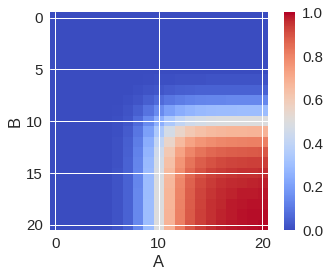

In [7]:
data = np.array([[Hill(A, 0.5, 8) * Hill(B, 0.5, 8)
                  for B in np.linspace(0, 1, 21)]
                 for A in np.linspace(0, 1, 21)])
plt.imshow(data, cmap='coolwarm')
plt.xlabel('A')
plt.ylabel('B')
plt.colorbar()
plt.clim(0, 1)
plt.show()

試すと

In [0]:
with reaction_rules():
    ~A > A | 0.2
    ~B > B | 0.2
    ~X > X | Hill(A, 0.2, 8) * Hill(B, 0.6, 8)
    X > ~X | 1.0
    ~Y > Y | Hill(A, 0.2, 8)
    Y > ~Y | 1.0

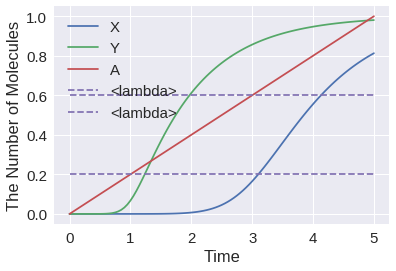

In [9]:
run_simulation(5, species_list=['X', 'Y', 'A'],
               opt_args=['-', lambda t: 0.2, '--', lambda t: 0.6, '--'])

## ORゲート

ORゲートは

<table>
  <tr><th>A</th><th>B</th><th>A OR B</th></tr>
  <tr><td>0</td><td>0</td><td>0</td></tr>
  <tr><td>1</td><td>0</td><td>1</td></tr>
  <tr><td>0</td><td>1</td><td>1</td></tr>
  <tr><td>1</td><td>1</td><td>1</td></tr>
</table>

入力のうちどちらか一方があれば良い

これは例えば

$$\frac{\mathrm{d}[X]}{\mathrm{d}t}=f(A,B)-k[X]=\frac{\left([A]/K_1\right)^{n_1}+\left([B]/K_2\right)^{n_2}}{1+\left([A]/K_1\right)^{n_1}+\left([B]/K_2\right)^{n_2}}-k[X]$$

In [0]:
def f(A, B, K1, K2, n1, n2):
    term1 = (A / K1) ** n1
    term2 = (B / K2) ** n1
    return (term1 + term2) / (1 + term1 + term2)

複雑に見えるが、$K_1=K_2$かつ$n_1=n_2$の場合を考えればヒル式と同じ

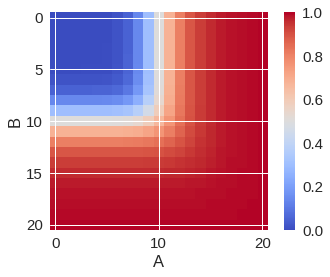

In [11]:
data = np.array([[f(A, B, 0.5, 0.5, 8, 8) for B in np.linspace(0, 1, 21)]
                 for A in np.linspace(0, 1, 21)])
plt.imshow(data, cmap='coolwarm')
plt.xlabel('A')
plt.ylabel('B')
plt.colorbar()
plt.clim(0, 1)
plt.show()

In [0]:
with reaction_rules():
    ~A > A | 0.2
    ~B > B | 0.2
    ~X > X | f(A, B, 0.2, 0.6, 8, 8)
    X > ~X | 1.0
    ~Y > Y | Hill(B, 0.6, 8)
    Y > ~Y | 1.0

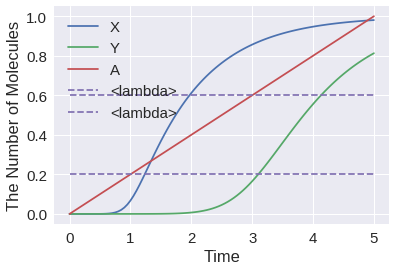

In [13]:
run_simulation(5, species_list=['X', 'Y', 'A'],
               opt_args=['-', lambda t: 0.2, '--', lambda t: 0.6, '--'])

実は分解を制御しても似たようなことはできる

$$\frac{\mathrm{d}[X]}{\mathrm{d}t}=f(A)-g(B)[X]$$
$$=\frac{[A]^{n_1}}{K_1^{n_1}+[A]^{n_1}}-\left[k_1+k_2\frac{K_2^{n_2}}{K_2^{n_2}+[B]^{n_2}}\right][X]$$

In [0]:
def Hill_compl(E, Km, nH):
    return Km ** nH / (Km ** nH + E ** nH)

上の式においてA、Bがそれぞれ0もしくは十分に存在する場合の定常状態を考えると

<table>
  <tr><th>A</th><th>B</th><th>A OR B</th></tr>
  <tr><td>0</td><td>0</td><td>0</td></tr>
  <tr><td>$\infty$</td><td>0</td><td>$\frac{1}{k1+k2}$</td></tr>
  <tr><td>0</td><td>$\infty$</td><td>0</td></tr>
  <tr><td>$\infty$</td><td>$\infty$</td><td>$\frac{1}{k1}$</td></tr>
</table>

$k_2$が十分大きければ、ANDゲートが実現できる

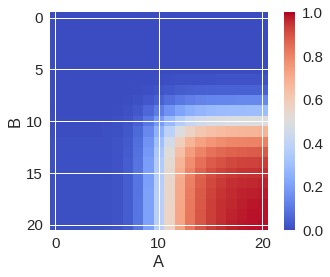

In [15]:
data = np.array([[Hill(A, 0.5, 8) / (1 + 100 * Hill_compl(B, 0.3, 8))
                  for B in np.linspace(0, 1, 21)]
                 for A in np.linspace(0, 1, 21)])
plt.imshow(data, cmap='coolwarm')
plt.xlabel('A')
plt.ylabel('B')
plt.colorbar()
plt.clim(0, 1)
plt.show()

In [0]:
with reaction_rules():
    ~A > A | 0.2
    ~B > B | 0.2
    ~X > X | Hill(A, 0.2, 8)
    X > ~X | (1.0 + 100 * Hill_compl(B, 0.36, 8)) * X
    ~Y > Y | Hill(A, 0.2, 8)
    Y > ~Y | 1.0

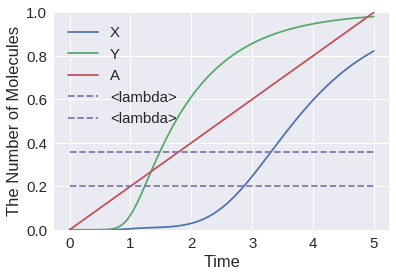

In [17]:
run_simulation(5, species_list=['X', 'Y', 'A'],
               opt_args=['-', lambda t: 0.2, '--', lambda t: 0.36, '--'],
               opt_kwargs={'ylim': (0, 1)})

## NOTゲート

先ほどみたようにヒル式$\frac{[A]^n}{K^n+[A]^n}$の相補関数$\frac{K^n}{K^n+[A]^n}$ $\left(=1-\frac{[A]^n}{K^n+[A]^n}\right)$はちょうどNOTゲートのようなことができる

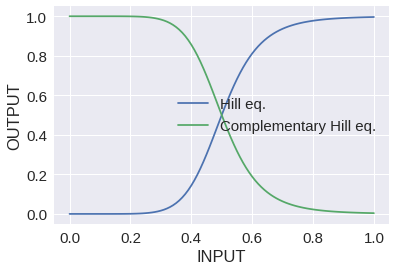

In [18]:
x = np.linspace(0, 1, 101)
nH = 8
plt.plot(x, [Hill(xi, 0.5, nH) for xi in x], label='Hill eq.')
plt.plot(x, [Hill_compl(xi, 0.5, nH) for xi in x],
         label='Complementary Hill eq.')
plt.legend(loc='best')
plt.xlabel('INPUT')
plt.ylabel('OUTPUT')
plt.show()

## フィードバック制御

これまでは一方向の制御だったが回路のようにすると時間的な挙動を制御できるようになる

例えば

$$A{\rightarrow}B{\rightarrow}C$$

のような反応だとAからBに流れてさらに下流のCへと蓄積していく

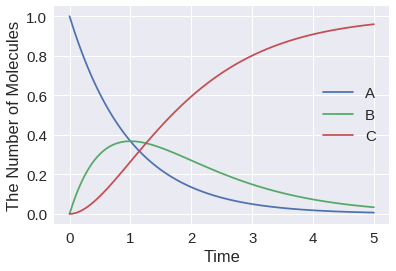

In [19]:
with reaction_rules():
    A > B | 1
    B > C | 1
    
run_simulation(5, {'A': 1})

ここにCの量が多くなると$A{\rightarrow}B$の反応を抑制するように制御を加えてみると

![Figure2-5](https://github.com/kaizu/ecell4-lectures/blob/master/images/Figure2-5.png?raw=1)

In [0]:
with reaction_rules():
    A > B | 1
    B > C | 1
    
obs = run_simulation(5, {'A': 1}, return_type='observer')

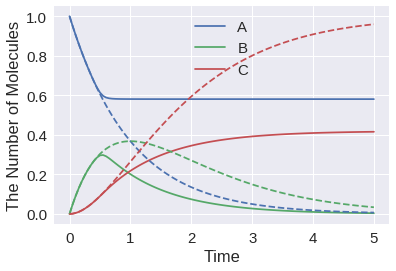

In [21]:
with reaction_rules():
    A > B | 1 * Hill_compl(C, 0.1, 8) * A
    B > C | 1
    
run_simulation(5, {'A': 1}, opt_args=('-', obs, '--'))

今度はさきほどのものに発現と分解を加えてみる

$${\emptyset}{\rightarrow}A{\rightarrow}B{\rightarrow}C{\rightarrow}{\emptyset}$$

Aだけが発現して、Cだけが分解する

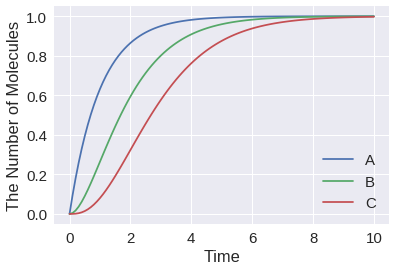

In [22]:
with reaction_rules():
    ~A > A | 1
    A > B | 1 > C | 1 > ~C | 1
    
run_simulation(10)

発現にCの量に応じた抑制を加えると

![Figure2-6](https://github.com/kaizu/ecell4-lectures/blob/master/images/Figure2-6.png?raw=1)

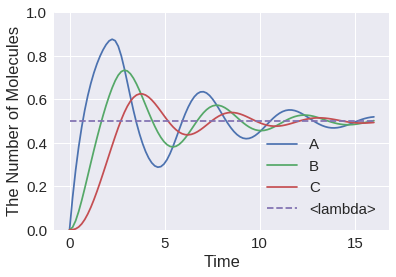

In [23]:
with reaction_rules():
    ~A > A | Hill_compl(C, 0.5, 8)
    A > B | 1 > C | 1 > ~C | 1
    
run_simulation(16, opt_args=['-', lambda t: 0.5, '--'],
               opt_kwargs={'ylim': (0, 1)})

## ネガティブフィードバック制御

さきほどのものは減衰していたが、ネガティブフィードバックを繰り返していくと安定な振動系にもできる

所謂、Repressilatorのようなもの（[Wikipedia](https://en.wikipedia.org/wiki/Repressilator)より）

![Repressilator_GRN.png](https://upload.wikimedia.org/wikipedia/commons/4/40/Repressilator_GRN.png)

![Figure2-4](https://github.com/kaizu/ecell4-lectures/blob/master/images/Figure2-4.png?raw=1)

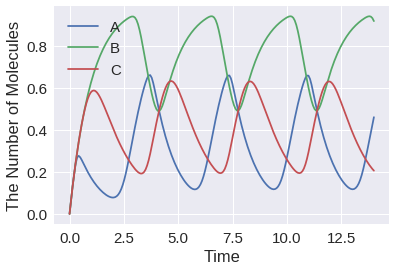

In [24]:
with reaction_rules():
    ~A > A | Hill_compl(C, 0.3, 8) > ~A | 1
    ~B > B | Hill_compl(A, 0.5, 8) > ~B | 1
    ~C > C | Hill_compl(B, 0.7, 8) > ~C | 1

run_simulation(np.linspace(0, 14, 201))

この場合はヒル係数が小さくなる（スイッチがゆるくなる）と振動は消えてしまう

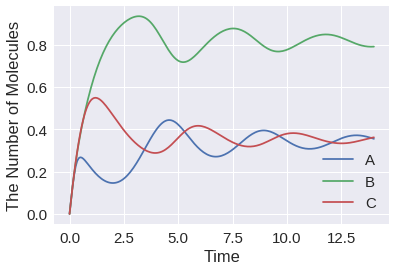

In [25]:
with reaction_rules():
    ~A > A | Hill_compl(C, 0.3, 4) > ~A | 1
    ~B > B | Hill_compl(A, 0.5, 4) > ~B | 1
    ~C > C | Hill_compl(B, 0.7, 4) > ~C | 1

run_simulation(np.linspace(0, 14, 201))

## フィードフォワード制御

逆に下流の反応を上流の分子によって制御することもある

また単純な一連の反応を考える

$$A{\rightarrow}B{\rightarrow}C$$

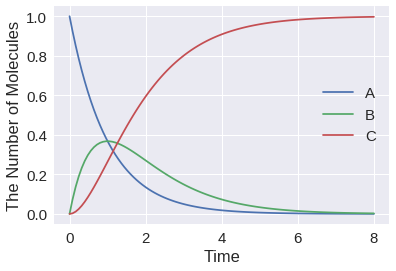

In [26]:
with reaction_rules():
    A > B | 1 > C | 1

run_simulation(8, {'A': 1})

ここにAの量が多いと$B{\rightarrow}C$の反応を抑制するように制御を加えてみると

![Figure2-3](https://github.com/kaizu/ecell4-lectures/blob/master/images/Figure2-3.png?raw=1)

In [0]:
with reaction_rules():
    A > B | 1 > C | 1

obs = run_simulation(8, {'A': 1}, return_type='observer')

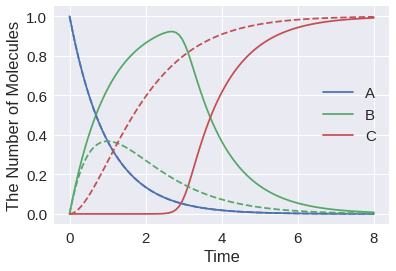

In [28]:
with reaction_rules():
    A > B | 1 > C | Hill_compl(A, 0.05, 8) * B

run_simulation(8, {'A': 1}, opt_args=('-', obs, '--'))

制御の仕方を変えてみると

## Incoherent Feedforward Loop (FFL)

![Figure2-2](https://github.com/kaizu/ecell4-lectures/blob/master/images/Figure2-2.png?raw=1)

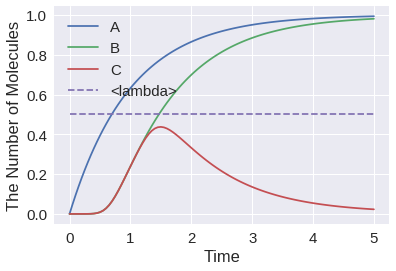

In [29]:
with reaction_rules():
    ~A > A | 1 > ~A | 1
    ~B > B | Hill(A, 0.5, 8) > ~B | 1
    ~C > C | Hill(A, 0.5, 8) * Hill_compl(B, 0.5, 8) > ~C | 1

run_simulation(5, opt_args=('-', lambda t: 0.5, '--'))

## Coherent Feedforward Loop (FFL)

![Figure2-1](https://github.com/kaizu/ecell4-lectures/blob/master/images/Figure2-1.png?raw=1)

In [0]:
with reaction_rules():
    ~B > B | Hill(A, 0.2, 8) > ~B | 1
    ~C > C | Hill(A, 0.2, 8) * Hill(B, 0.5, 8) > ~C | 1

In [0]:
from ecell4_base.core import *
from ecell4_base import ode

m = get_model()
w = ode.World()
sim = ode.Simulator(w, m)
obs = FixedIntervalNumberObserver(0.01, ['A', 'B', 'C'])

sim.run(1, obs)
w.set_value(Species('A'), 1); sim.initialize()
sim.run(0.3, obs)
w.set_value(Species('A'), 0)
sim.initialize()
sim.run(4, obs)
w.set_value(Species('A'), 1)
sim.initialize()
sim.run(1.5, obs)
w.set_value(Species('A'), 0)
sim.initialize()
sim.run(3.2, obs)

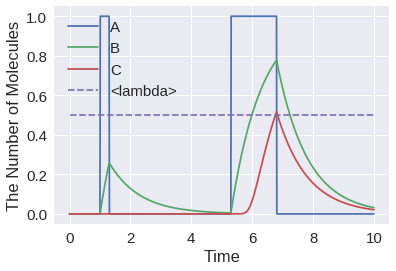

In [32]:
viz.plot_number_observer(obs, '-', lambda t: 0.5, '--')